### 1. Setup and configuration

1. Setup and Configuration

    Imports and Settings

    Helper Functions
    
    Database Connection

In [8]:
# Essential imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import os
import json
from IPython.display import display, HTML

# Optional: Set prettier defaults for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

# Database connection function
def get_db_connection(db_path='../../data/database/football_data.db'):
    """Establish a connection to the SQLite database with row factory enabled."""
    conn = sqlite3.connect(db_path)
    conn.row_factory = sqlite3.Row
    return conn

# Helper function to execute queries and return pandas DataFrames
def execute_query(query, conn=None, close_conn=False):
    """Execute SQL query and return results as a pandas DataFrame."""
    if conn is None:
        conn = get_db_connection()
        close_conn = True  # Close connection if we opened it
        
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f"Error executing query: {e}")
        print(f"Query: {query}")
        return pd.DataFrame()  # Return empty dataframe on error
    finally:
        if close_conn and conn:
            conn.close()

# Helper to create section headers in the notebook
def display_section_header(title, level=1):
    """Display formatted section header for better notebook organization."""
    if level == 1:
        display(HTML(f"<h1 style='color:#1E88E5'>{title}</h1>"))
    elif level == 2:
        display(HTML(f"<h2 style='color:#43A047'>{title}</h2>"))
    else:
        display(HTML(f"<h3 style='color:#FB8C00'>{title}</h3>"))

In [7]:
import os
print(os.getcwd())

c:\Users\ADMIN\OneDrive\3_Business\Foot_ball_Data_Retriev\src\utils


2. Database Overview

│   ├── Table Summary

│   └── Schema Inspection

In [10]:
def get_database_overview(conn=None):
    """Display tables in the database and their row counts."""
    close_conn = False
    if conn is None:
        conn = get_db_connection()
        close_conn = True
    
    cursor = conn.cursor()

    # Get list of tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [row[0] for row in cursor.fetchall()]
    
    overview = []
    for table in tables:
        try:
            cursor.execute(f"SELECT COUNT(*) FROM {table};")
            count = cursor.fetchone()[0]
            
            # Get column info
            cursor.execute(f"PRAGMA table_info({table});")
            columns = cursor.fetchall()
            column_count = len(columns)
            
            # Get primary key info
            primary_key_columns = [col[1] for col in columns if col[5] > 0]  # col[5] > 0 means part of primary key
            
            overview.append({
                'Table': table,
                'Rows': count,
                'Columns': column_count,
                'Primary Key': ', '.join(primary_key_columns) if primary_key_columns else 'None'
            })
        except Exception as e:
            overview.append({
                'Table': table,
                'Rows': f"Error: {e}",
                'Columns': 'N/A',
                'Primary Key': 'N/A'
            })
    
    if close_conn:
        conn.close()
    
    return pd.DataFrame(overview)

# Execute the function
db_overview = get_database_overview()
display(db_overview)

,Table,Rows,Columns,Primary Key
0,leagues,25,13,league_id
1,teams,2508,11,team_id
2,sqlite_sequence,2,2,None
3,seasons,26,12,season_id
4,schedules,6698,15,fixture_id
5,fixture_stats,17940,42,id
6,fixture_odds,154371,22,id


3. Foundational Coverage & Completeness

│   ├── 3.1 Overall Fixture Ingestion

│   ├── 3.2 Stats Record Availability

│   ├── 3.3 Critical Period Coverage

│   ├── 3.4 Team Coverage

│   ├── 3.5 Required Stats Completeness

│   └── 3.6 Home/Away Balance

,season_id,league_name,season_name,fixture_count
0,23672,Championship,2024/2025,552
1,23676,La Liga 2,2024/2025,462
2,23614,Premier League,2024/2025,380
3,23621,La Liga,2024/2025,380
4,23746,Serie A,2024/2025,380
5,23839,Serie B,2024/2025,380
6,23851,Super Lig,2024/2025,342
7,23589,Pro League,2024/2025,312
8,23578,Ekstraklasa,2024/2025,306
9,23628,Eredivisie,2024/2025,306


Total fixtures in database: 6698
Average fixtures per season: 304.45
Median fixtures per season: 306.00


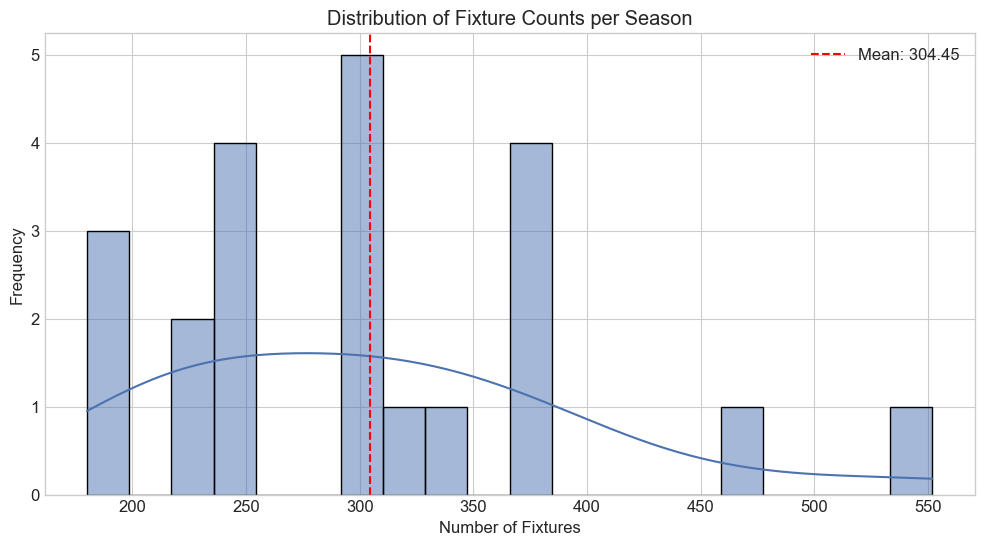

In [11]:
# Get scheduled fixture counts per season and league
season_fixture_counts = execute_query("""
    SELECT 
        s.season_id,
        l.name AS league_name,
        se.name AS season_name,
        COUNT(*) AS fixture_count
    FROM schedules s
    LEFT JOIN leagues l ON s.league_id = l.league_id
    LEFT JOIN seasons se ON s.season_id = se.season_id
    GROUP BY s.season_id, l.name, se.name
    ORDER BY fixture_count DESC
""")

# Display the top leagues by fixture count
display(season_fixture_counts.head(15))

# Calculate some basic statistics
total_fixtures = season_fixture_counts['fixture_count'].sum()
avg_fixtures_per_season = season_fixture_counts['fixture_count'].mean()
median_fixtures_per_season = season_fixture_counts['fixture_count'].median()

print(f"Total fixtures in database: {total_fixtures}")
print(f"Average fixtures per season: {avg_fixtures_per_season:.2f}")
print(f"Median fixtures per season: {median_fixtures_per_season:.2f}")

# Visualize fixture distribution across seasons
plt.figure(figsize=(12, 6))
sns.histplot(season_fixture_counts['fixture_count'], bins=20, kde=True)
plt.title('Distribution of Fixture Counts per Season')
plt.xlabel('Number of Fixtures')
plt.ylabel('Frequency')
plt.axvline(avg_fixtures_per_season, color='red', linestyle='--', label=f'Mean: {avg_fixtures_per_season:.2f}')
plt.legend()
plt.show()

# Check for major leagues with suspiciously low fixture counts (potentially incomplete)
low_count_threshold = 30  # Adjust based on knowledge of league formats
low_count_leagues = season_fixture_counts[
    (season_fixture_counts['fixture_count'] < low_count_threshold) & 
    (season_fixture_counts['league_name'].notnull())
]

if not low_count_leagues.empty:
    print("\nPotentially incomplete leagues (low fixture counts):")
    display(low_count_leagues)

In [14]:
# Query to find 'Finished' fixtures that lack stats
fixtures_without_stats = execute_query("""
    SELECT 
        s.fixture_id,
        s.league_id,
        l.name AS league_name,
        s.season_id,
        se.name AS season_name,
        s.home_team_id,
        ht.name AS home_team,
        s.away_team_id,
        at.name AS away_team,
        s.start_time,
        s.status
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    LEFT JOIN leagues l ON s.league_id = l.league_id
    LEFT JOIN seasons se ON s.season_id = se.season_id
    LEFT JOIN teams ht ON s.home_team_id = ht.team_id
    LEFT JOIN teams at ON s.away_team_id = at.team_id
    WHERE 
        s.status = 'FT' 
        AND fs.fixture_id IS NULL
    ORDER BY s.start_time DESC
""")

# Display summary
total_finished = execute_query("SELECT COUNT(*) AS count FROM schedules WHERE status = 'FT'").iloc[0]['count']
missing_stats_count = len(fixtures_without_stats)
missing_percentage = (missing_stats_count / total_finished * 100) if total_finished > 0 else 0

print(f"Total finished fixtures: {total_finished}")
print(f"Fixtures missing stats: {missing_stats_count} ({missing_percentage:.2f}%)")

# Display sample of fixtures without stats
if not fixtures_without_stats.empty:
    display(fixtures_without_stats.head(100))
    
    # Group by league to see if some leagues are systematically missing stats
    missing_by_league = fixtures_without_stats.groupby(['league_name'])['fixture_id'].count().reset_index()
    missing_by_league.columns = ['League', 'Fixtures Missing Stats']
    missing_by_league = missing_by_league.sort_values('Fixtures Missing Stats', ascending=False)
    
    print("\nLeagues with most fixtures missing stats:")
    display(missing_by_league.head(10))

Total finished fixtures: 5449
Fixtures missing stats: 532 (9.76%)


,fixture_id,league_id,league_name,season_id,season_name,home_team_id,home_team,away_team_id,away_team,start_time,status
0,19145047,567,La Liga 2,23676,2024/2025,60,SD Eibar,126,Málaga,2025-04-21 18:30:00,FT
1,19144091,9,Championship,23672,2024/2025,22,Hull City,99,Preston North End,2025-04-21 14:00:00,FT
2,19144093,9,Championship,23672,2024/2025,71,Leeds United,26,Stoke City,2025-04-21 14:00:00,FT
3,19144098,9,Championship,23672,2024/2025,110,Plymouth Argyle,117,Coventry City,2025-04-21 14:00:00,FT
4,19144107,9,Championship,23672,2024/2025,10,West Bromwich Albion,24,Derby County,2025-04-21 14:00:00,FT
5,19155387,384,Serie A,23746,2024/2025,8513,Bologna,2930,Inter,2025-04-20 16:00:00,FT
6,19172296,600,Super Lig,23851,2024/2025,88,Fenerbahçe,643,Kayserispor,2025-04-20 16:00:00,FT
7,19139914,301,Ligue 1,23643,2024/2025,450,Nice,776,Angers SCO,2025-04-20 15:15:00,FT
8,19139919,301,Ligue 1,23643,2024/2025,1028,Reims,289,Toulouse,2025-04-20 15:15:00,FT
9,19149045,609,None,23703,2024/2025,5562,Veres,6061,Chornomorets,2025-04-20 15:00:00,FT



Leagues with most fixtures missing stats:


,League,Fixtures Missing Stats
11,Premier League,82
4,Championship,64
8,La Liga 2,59
6,Eredivisie,48
7,La Liga,43
14,Serie A,39
10,Ligue 1,38
3,Bundesliga,24
17,Super Lig,23
13,Pro League,21


In [15]:
# Query fixtures that have any stats but are missing first-half stats
fixtures_missing_first_half = execute_query("""
    SELECT 
        fs.fixture_id,
        s.league_id,
        l.name AS league_name,
        s.status,
        GROUP_CONCAT(DISTINCT fs.period) AS available_periods
    FROM fixture_stats fs
    JOIN schedules s ON fs.fixture_id = s.fixture_id
    LEFT JOIN leagues l ON s.league_id = l.league_id
    WHERE fs.fixture_id NOT IN (
        SELECT DISTINCT fixture_id 
        FROM fixture_stats 
        WHERE period = 'first_half'
    )
    GROUP BY fs.fixture_id, s.league_id, l.name, s.status
    ORDER BY fs.fixture_id
""")

total_fixtures_with_stats = execute_query("""
    SELECT COUNT(DISTINCT fixture_id) AS count FROM fixture_stats
""").iloc[0]['count']

missing_first_half_count = len(fixtures_missing_first_half)
missing_percentage = (missing_first_half_count / total_fixtures_with_stats * 100) if total_fixtures_with_stats > 0 else 0

print(f"Total fixtures with any stats: {total_fixtures_with_stats}")
print(f"Fixtures missing first-half stats: {missing_first_half_count} ({missing_percentage:.2f}%)")

if not fixtures_missing_first_half.empty:
    display(fixtures_missing_first_half.head(10))
    
    # Group by available periods to see patterns
    period_patterns = fixtures_missing_first_half['available_periods'].value_counts().reset_index()
    period_patterns.columns = ['Available Periods', 'Count']
    
    print("\nDistribution of available periods (when first_half is missing):")
    display(period_patterns)

Total fixtures with any stats: 4917
Fixtures missing first-half stats: 512 (10.41%)


,fixture_id,league_id,league_name,status,available_periods
0,19129885,244,1. HNL,FT,second_half
1,19129891,244,1. HNL,FT,second_half
2,19129895,244,1. HNL,FT,second_half
3,19129897,244,1. HNL,FT,second_half
4,19129898,244,1. HNL,FT,second_half
5,19129900,244,1. HNL,FT,second_half
6,19129905,244,1. HNL,FT,second_half
7,19129906,244,1. HNL,FT,second_half
8,19129907,244,1. HNL,FT,second_half
9,19129913,244,1. HNL,FT,second_half



Distribution of available periods (when first_half is missing):


,Available Periods,Count
0,second_half,512


In [16]:
# Check team coverage for first_half period
team_coverage = execute_query("""
    SELECT 
        fixture_id,
        COUNT(DISTINCT team_id) AS team_count
    FROM fixture_stats
    WHERE period = 'first_half'
    GROUP BY fixture_id
    HAVING team_count != 2  -- We want exactly 2 teams
    ORDER BY team_count
""")

total_fixtures_first_half = execute_query("""
    SELECT COUNT(DISTINCT fixture_id) AS count 
    FROM fixture_stats 
    WHERE period = 'first_half'
""").iloc[0]['count']

incomplete_teams_count = len(team_coverage)
incomplete_percentage = (incomplete_teams_count / total_fixtures_first_half * 100) if total_fixtures_first_half > 0 else 0

print(f"Total fixtures with first-half stats: {total_fixtures_first_half}")
print(f"Fixtures with incomplete team coverage: {incomplete_teams_count} ({incomplete_percentage:.2f}%)")

if not team_coverage.empty:
    print("\nFixtures with abnormal team count (not exactly 2 teams):")
    display(team_coverage)
    
    # Get details for a sample of these fixtures
    if not team_coverage.empty:
        sample_ids = tuple(team_coverage['fixture_id'].head(5).tolist())
        
        # Handle case of single ID differently (SQL syntax)
        if len(sample_ids) == 1:
            sample_ids = f"({sample_ids[0]})"
        
        sample_details = execute_query(f"""
            SELECT 
                fs.fixture_id,
                fs.team_id,
                t.name AS team_name,
                fs.period,
                s.home_team_id,
                s.away_team_id
            FROM fixture_stats fs
            JOIN schedules s ON fs.fixture_id = s.fixture_id
            LEFT JOIN teams t ON fs.team_id = t.team_id
            WHERE fs.fixture_id IN {sample_ids}
            ORDER BY fs.fixture_id, fs.team_id
        """)
        
        print("\nSample details for fixtures with abnormal team count:")
        display(sample_details)

Total fixtures with first-half stats: 4405
Fixtures with incomplete team coverage: 1 (0.02%)

Fixtures with abnormal team count (not exactly 2 teams):


,fixture_id,team_count
0,19172176,1



Sample details for fixtures with abnormal team count:


,fixture_id,team_id,team_name,period,home_team_id,away_team_id
0,19172176,88,Fenerbahçe,first_half,2632,88


Total first-half stat records: 8809

NULL Value Analysis for Required Statistics:


,Statistic,NULL Count,NULL %
2,red_cards,5397,61.27
0,goals,2203,25.01
4,shots_blocked,990,11.24
7,saves,903,10.25
10,shots_insidebox,645,7.32
3,tackles,467,5.30
5,successful_passes_percentage,390,4.43
9,shots_total,218,2.47
1,fouls,103,1.17
8,attacks,68,0.77


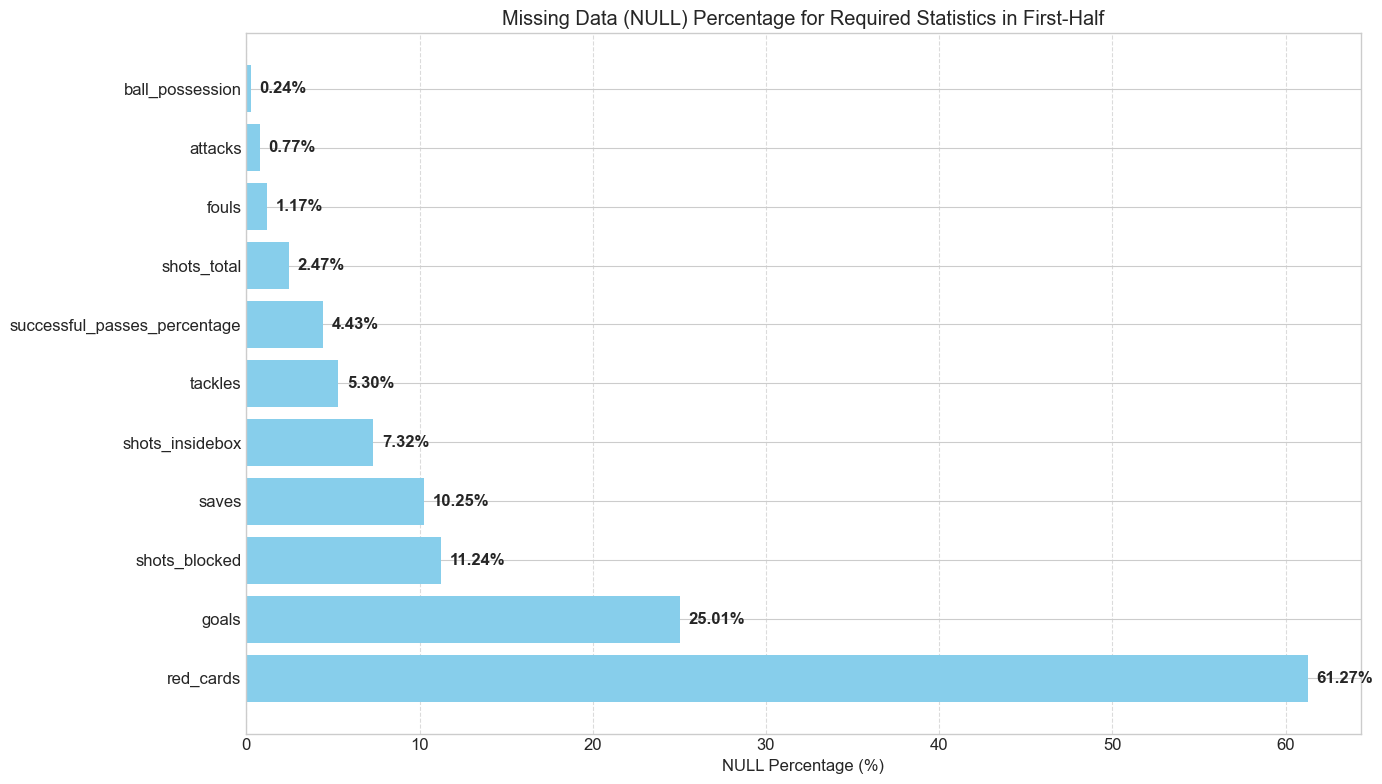


Fixtures with ALL required stats NULL for first-half: 0


In [17]:
# List of required columns for half-time modeling
required_stats_cols = [
    "goals", "fouls", "red_cards", "tackles", "shots_blocked",
    "successful_passes_percentage", "ball_possession", "saves",
    "attacks", "shots_total", "shots_insidebox"
]

# Build the query dynamically to check NULL percentage for each column
null_check_parts = []
for col in required_stats_cols:
    null_check_parts.append(f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_null_count")
    null_check_parts.append(f"ROUND(SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS {col}_null_percent")

query = f"""
    SELECT 
        COUNT(*) AS total_records,
        {', '.join(null_check_parts)}
    FROM fixture_stats
    WHERE period = 'first_half'
"""

null_stats = execute_query(query)

# Format into a more readable DataFrame
null_analysis = pd.DataFrame({
    'Statistic': required_stats_cols,
    'NULL Count': [null_stats[f"{col}_null_count"].iloc[0] for col in required_stats_cols],
    'NULL %': [null_stats[f"{col}_null_percent"].iloc[0] for col in required_stats_cols]
})

# Sort by NULL percentage (descending)
null_analysis = null_analysis.sort_values('NULL %', ascending=False)

print(f"Total first-half stat records: {null_stats['total_records'].iloc[0]}")
print("\nNULL Value Analysis for Required Statistics:")
display(null_analysis)

# Visualize NULL percentages
plt.figure(figsize=(14, 8))
bars = plt.barh(null_analysis['Statistic'], null_analysis['NULL %'], color='skyblue')
plt.xlabel('NULL Percentage (%)')
plt.title('Missing Data (NULL) Percentage for Required Statistics in First-Half')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels to bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Check for fixtures where ALL required stats are NULL (completely missing data)
all_null_fixtures = execute_query(f"""
    SELECT 
        fs.fixture_id,
        s.home_team_id,
        ht.name AS home_team,
        s.away_team_id,
        at.name AS away_team,
        s.start_time,
        s.status,
        fs.team_id,
        t.name AS team_name
    FROM fixture_stats fs
    JOIN schedules s ON fs.fixture_id = s.fixture_id
    LEFT JOIN teams ht ON s.home_team_id = ht.team_id
    LEFT JOIN teams at ON s.away_team_id = at.team_id
    LEFT JOIN teams t ON fs.team_id = t.team_id
    WHERE 
        fs.period = 'first_half'
        AND {' AND '.join([f"{col} IS NULL" for col in required_stats_cols])}
    ORDER BY s.start_time DESC
""")

print(f"\nFixtures with ALL required stats NULL for first-half: {len(all_null_fixtures)}")
if not all_null_fixtures.empty:
    display(all_null_fixtures.head(10))

Home/Away Balance Analysis (across 373 team-seasons):
Average difference between home/away matches: 0.02
Median difference: 0.00
Maximum difference: 2

Most imbalanced team schedules:


,season_id,season_name,team_id,team_name,home_matches,away_matches,total_matches,balance_diff
0,23617,2024/2025,362,St. Gallen,18,20,38,2
1,23617,2024/2025,2357,Lausanne Sport,20,18,38,2
2,23690,2024/2025,309,Motherwell,18,20,38,2
3,23690,2024/2025,496,St. Mirren,20,18,38,2
4,23672,2024/2025,2,Blackburn Rovers,23,23,46,0
5,23672,2024/2025,3,Sunderland,23,23,46,0
6,23672,2024/2025,5,Portsmouth,23,23,46,0
7,23672,2024/2025,7,Middlesbrough,23,23,46,0
8,23672,2024/2025,10,West Bromwich Albion,23,23,46,0
9,23672,2024/2025,21,Sheffield United,23,23,46,0


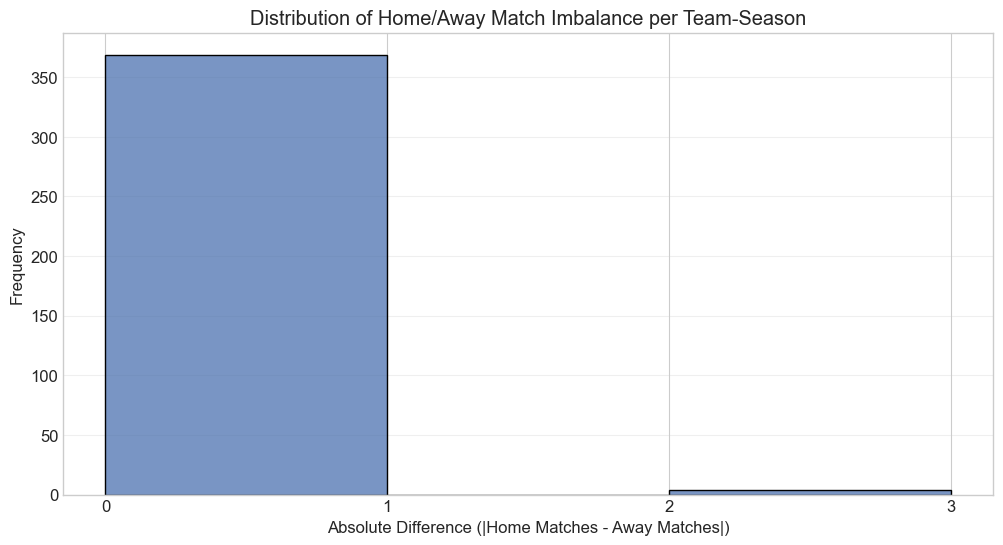

Teams with perfect home/away balance: 369 (98.93%)
Teams with minor imbalance (diff ≤ 2): 373 (100.00%)


In [18]:
# Check home/away balance per team and season
home_away_balance = execute_query("""
    SELECT 
        s.season_id,
        se.name AS season_name,
        t.team_id,
        t.name AS team_name,
        SUM(CASE WHEN s.home_team_id = t.team_id THEN 1 ELSE 0 END) AS home_matches,
        SUM(CASE WHEN s.away_team_id = t.team_id THEN 1 ELSE 0 END) AS away_matches,
        COUNT(*) AS total_matches,
        ABS(SUM(CASE WHEN s.home_team_id = t.team_id THEN 1 ELSE 0 END) - 
            SUM(CASE WHEN s.away_team_id = t.team_id THEN 1 ELSE 0 END)) AS balance_diff
    FROM schedules s
    JOIN teams t ON (t.team_id = s.home_team_id OR t.team_id = s.away_team_id)
    LEFT JOIN seasons se ON s.season_id = se.season_id
    GROUP BY s.season_id, se.name, t.team_id, t.name
    HAVING total_matches >= 10  -- Ignore teams with very few matches
    ORDER BY balance_diff DESC, total_matches DESC
""")

# Calculate summary statistics
avg_diff = home_away_balance['balance_diff'].mean()
median_diff = home_away_balance['balance_diff'].median()
max_diff = home_away_balance['balance_diff'].max()

print(f"Home/Away Balance Analysis (across {len(home_away_balance)} team-seasons):")
print(f"Average difference between home/away matches: {avg_diff:.2f}")
print(f"Median difference: {median_diff:.2f}")
print(f"Maximum difference: {max_diff}")

# Display teams with the most imbalanced schedules
print("\nMost imbalanced team schedules:")
display(home_away_balance.head(10))

# Visualize the distribution of home/away imbalance
plt.figure(figsize=(12, 6))
sns.histplot(home_away_balance['balance_diff'], bins=range(0, int(max_diff) + 2), kde=False)
plt.title('Distribution of Home/Away Match Imbalance per Team-Season')
plt.xlabel('Absolute Difference (|Home Matches - Away Matches|)')
plt.ylabel('Frequency')
plt.xticks(range(0, int(max_diff) + 2))
plt.grid(axis='y', alpha=0.3)
plt.show()

# Calculate percentage of teams with perfect balance or minor imbalance
perfect_balance = (home_away_balance['balance_diff'] == 0).sum()
minor_imbalance = (home_away_balance['balance_diff'] <= 2).sum()

perfect_pct = perfect_balance / len(home_away_balance) * 100
minor_pct = minor_imbalance / len(home_away_balance) * 100

print(f"Teams with perfect home/away balance: {perfect_balance} ({perfect_pct:.2f}%)")
print(f"Teams with minor imbalance (diff ≤ 2): {minor_imbalance} ({minor_pct:.2f}%)")

4. Technical Integrity & Schema Validation

│   ├── 4.1 ID Consistency

│   ├── 4.2 Duplicate Entry Detection

│   ├── 4.3 Schema Consistency

│   └── 4.4 Timestamp Validity

In [19]:
# Check fixture_id consistency between schedules and fixture_stats
fixture_id_consistency = execute_query("""
    SELECT 
        'fixture_stats' AS table_name,
        COUNT(DISTINCT fs.fixture_id) AS unique_fixture_ids,
        SUM(CASE WHEN s.fixture_id IS NULL THEN 1 ELSE 0 END) AS orphaned_ids,
        ROUND(SUM(CASE WHEN s.fixture_id IS NULL THEN 1 ELSE 0 END) * 100.0 / 
              COUNT(DISTINCT fs.fixture_id), 2) AS orphaned_percent
    FROM 
        (SELECT DISTINCT fixture_id FROM fixture_stats) fs
    LEFT JOIN 
        schedules s ON fs.fixture_id = s.fixture_id
    
    UNION ALL
    
    SELECT 
        'fixture_odds' AS table_name,
        COUNT(DISTINCT fo.fixture_id) AS unique_fixture_ids,
        SUM(CASE WHEN s.fixture_id IS NULL THEN 1 ELSE 0 END) AS orphaned_ids,
        ROUND(SUM(CASE WHEN s.fixture_id IS NULL THEN 1 ELSE 0 END) * 100.0 / 
              COUNT(DISTINCT fo.fixture_id), 2) AS orphaned_percent
    FROM 
        (SELECT DISTINCT fixture_id FROM fixture_odds) fo
    LEFT JOIN 
        schedules s ON fo.fixture_id = s.fixture_id
""")

print("Fixture ID Consistency Check:")
display(fixture_id_consistency)

# Check team_id consistency between fixture_stats and schedules
team_id_consistency = execute_query("""
    SELECT 
        COUNT(DISTINCT fs.fixture_id) AS fixtures_checked,
        SUM(CASE 
            WHEN fs.team_id != s.home_team_id AND fs.team_id != s.away_team_id 
            THEN 1 ELSE 0 
        END) AS inconsistent_team_ids,
        ROUND(SUM(CASE 
            WHEN fs.team_id != s.home_team_id AND fs.team_id != s.away_team_id 
            THEN 1 ELSE 0 
        END) * 100.0 / COUNT(*), 2) AS inconsistent_percent
    FROM fixture_stats fs
    JOIN schedules s ON fs.fixture_id = s.fixture_id
""")

print("\nTeam ID Consistency Check:")
display(team_id_consistency)

# If inconsistencies found, display some examples
if team_id_consistency['inconsistent_team_ids'].iloc[0] > 0:
    inconsistent_examples = execute_query("""
        SELECT 
            fs.fixture_id,
            fs.team_id AS stats_team_id,
            t_stats.name AS stats_team_name,
            s.home_team_id,
            t_home.name AS home_team_name,
            s.away_team_id,
            t_away.name AS away_team_name
        FROM fixture_stats fs
        JOIN schedules s ON fs.fixture_id = s.fixture_id
        LEFT JOIN teams t_stats ON fs.team_id = t_stats.team_id
        LEFT JOIN teams t_home ON s.home_team_id = t_home.team_id
        LEFT JOIN teams t_away ON s.away_team_id = t_away.team_id
        WHERE 
            fs.team_id != s.home_team_id AND 
            fs.team_id != s.away_team_id
        LIMIT 10
    """)
    
    print("\nExamples of team ID inconsistencies:")
    display(inconsistent_examples)

Fixture ID Consistency Check:


,table_name,unique_fixture_ids,orphaned_ids,orphaned_percent
0,fixture_stats,4917,0,0.0
1,fixture_odds,5448,0,0.0



Team ID Consistency Check:


,fixtures_checked,inconsistent_team_ids,inconsistent_percent
0,4917,0,0.0


In [26]:
# Check for duplicates in fixture_stats
duplicate_stats = execute_query("""
    SELECT 
        fixture_id, 
        team_id, 
        period, 
        COUNT(*) AS duplicate_count
    FROM fixture_stats
    GROUP BY fixture_id, team_id, period
    HAVING COUNT(*) > 1
    ORDER BY duplicate_count DESC
""")

if len(duplicate_stats) > 0:
    print(f"Found {len(duplicate_stats)} sets of duplicate entries in fixture_stats:")
    display(duplicate_stats)
    
    # Get a sample of the actual duplicate records
    if not duplicate_stats.empty:
        sample_fixture = duplicate_stats.iloc[0]['fixture_id']
        sample_team = duplicate_stats.iloc[0]['team_id']
        sample_period = duplicate_stats.iloc[0]['period']
        
        sample_duplicates = execute_query(f"""
            SELECT *
            FROM fixture_stats
            WHERE 
                fixture_id = {sample_fixture} AND
                team_id = {sample_team} AND
                period = '{sample_period}'
            ORDER BY id
        """)
        
        print(f"\nSample duplicates for fixture_id={sample_fixture}, team_id={sample_team}, period='{sample_period}':")
        display(sample_duplicates)
else:
    print("No duplicates found in fixture_stats based on (fixture_id, team_id, period).")

# Check for duplicates in fixture_odds if the table exists
try:
    duplicate_odds = execute_query("""
        SELECT 
            fixture_id, 
            market_id, 
            bookmaker_id, 
            label,
            value,
            handicap,
            COUNT(*) AS duplicate_count
        FROM fixture_odds
        GROUP BY fixture_id, market_id, bookmaker_id, label, value, handicap
        HAVING COUNT(*) > 1
        ORDER BY duplicate_count DESC
    """)
    
    if len(duplicate_odds) > 0:
        print(f"\nFound {len(duplicate_odds)} sets of duplicate entries in fixture_odds:")
        display(duplicate_odds)
    else:
        print("\nNo duplicates found in fixture_odds based on (fixture_id, market_id, bookmaker_id, label, value, handicap).")
except:
    print("\nCould not check fixture_odds table (may not exist).")

No duplicates found in fixture_stats based on (fixture_id, team_id, period).

No duplicates found in fixture_odds based on (fixture_id, market_id, bookmaker_id, label, value, handicap).


In [27]:
# Function to check if table columns match the expected schema
def check_schema_consistency(conn=None):
    """Check if database tables have all expected columns defined in data/storage.py."""
    close_conn = False
    if conn is None:
        conn = get_db_connection()
        close_conn = True
    
    # Expected columns based on data/storage.py definitions
    # Note: This is simplified for the notebook - in reality, you'd import these from the actual module
    expected_schemas = {
        'leagues': [
            'league_id', 'sport_id', 'country_id', 'name', 'active', 'short_code', 
            'image_path', 'type', 'sub_type', 'last_played_at', 'category', 
            'current_season_id', 'created_at', 'updated_at'
        ],
        'seasons': [
            'season_id', 'league_id', 'league_name', 'sport_id', 'name', 'is_current', 
            'finished', 'pending', 'starting_at', 'ending_at', 
            'standings_recalculated_at', 'created_at', 'updated_at'
        ],
        'teams': [
            'team_id', 'name', 'short_code', 'country_id', 'logo_url', 'venue_id',
            'founded', 'type', 'national_team', 'created_at', 'updated_at'
        ],
        'schedules': [
            'fixture_id', 'season_id', 'league_id', 'round_id', 'home_team_id', 
            'away_team_id', 'start_time', 'status', 'home_score', 'away_score', 
            'result', 'result_info', 'round_finished', 'created_at', 'updated_at'
        ],
        'fixture_stats': [
            'id', 'fixture_id', 'team_id', 'period', 'goals', 'shots_on_target', 
            'shots_off_target', 'ball_possession', 'corners', 'fouls', 'yellow_cards', 
            'red_cards', 'shots_total', 'shots_blocked', 'offsides', 'saves', 
            'hit_woodwork', 'shots_insidebox', 'successful_dribbles', 
            'successful_dribbles_percentage', 'successful_passes', 
            'successful_passes_percentage', 'shots_outsidebox', 'dribble_attempts', 
            'throwins', 'assists', 'accurate_crosses', 'total_crosses', 'penalties', 
            'passes', 'attacks', 'challenges', 'tackles', 'interceptions', 
            'long_passes', 'goal_kicks', 'key_passes', 'dangerous_attacks', 
            'substitutions', 'timestamp', 'created_at', 'updated_at'
        ],
        'fixture_odds': [
            'id', 'fixture_id', 'market_id', 'bookmaker_id', 'label', 'name',
            'market_description', 'value', 'probability', 'dp3', 'fractional',
            'american', 'winning', 'stopped', 'total', 'handicap', 'participants',
            'api_created_at', 'original_label', 'latest_bookmaker_update', 
            'created_at', 'updated_at'
        ]
    }
    
    results = []
    cursor = conn.cursor()
    
    for table, expected_columns in expected_schemas.items():
        try:
            # Get actual columns from database
            cursor.execute(f"PRAGMA table_info({table});")
            actual_columns = [row[1] for row in cursor.fetchall()]
            
            # Find missing and extra columns
            missing_columns = [col for col in expected_columns if col not in actual_columns]
            extra_columns = [col for col in actual_columns if col not in expected_columns]
            
            results.append({
                'Table': table,
                'Expected_Column_Count': len(expected_columns),
                'Actual_Column_Count': len(actual_columns),
                'Missing_Columns': ', '.join(missing_columns) if missing_columns else 'None',
                'Extra_Columns': ', '.join(extra_columns) if extra_columns else 'None',
                'Is_Consistent': len(missing_columns) == 0,
                'Status': 'Present' if len(actual_columns) > 0 else 'Missing'
            })
        except:
            results.append({
                'Table': table,
                'Expected_Column_Count': len(expected_columns),
                'Actual_Column_Count': 0,
                'Missing_Columns': 'Table not found',
                'Extra_Columns': 'N/A',
                'Is_Consistent': False,
                'Status': 'Missing'
            })
    
    if close_conn:
        conn.close()
    
    return pd.DataFrame(results)

# Execute the function
schema_consistency = check_schema_consistency()
display(schema_consistency)

# Highlight any inconsistencies
inconsistent_tables = schema_consistency[~schema_consistency['Is_Consistent']]
if not inconsistent_tables.empty:
    print("\nTables with schema inconsistencies:")
    display(inconsistent_tables)
else:
    print("\nAll existing tables have consistent schemas as defined in data/storage.py")

,Table,Expected_Column_Count,Actual_Column_Count,Missing_Columns,Extra_Columns,Is_Consistent,Status
0,leagues,14,13,current_season_id,None,False,Present
1,seasons,13,12,league_name,None,False,Present
2,teams,11,11,None,None,True,Present
3,schedules,15,15,None,None,True,Present
4,fixture_stats,42,42,None,None,True,Present
5,fixture_odds,22,22,None,None,True,Present



Tables with schema inconsistencies:


,Table,Expected_Column_Count,Actual_Column_Count,Missing_Columns,Extra_Columns,Is_Consistent,Status
0,leagues,14,13,current_season_id,None,False,Present
1,seasons,13,12,league_name,None,False,Present


,table_name,total_rows,null_created_at,null_updated_at,illogical_timestamps,earliest_created,latest_created,earliest_updated,latest_updated
0,leagues,25,0,0,0,2025-04-12 15:42:43,2025-04-12 15:42:43,2025-04-12 15:42:43,2025-04-12 15:42:43
1,seasons,26,0,0,0,2025-04-16 03:09:26,2025-04-16 03:09:26,2025-04-16 03:09:26,2025-04-16 03:09:26
2,teams,2508,0,0,0,2025-04-12 16:27:39,2025-04-12 16:27:39,2025-04-12 16:27:39,2025-04-12 16:27:39
3,schedules,6698,0,0,0,2025-04-23 14:48:43,2025-04-23 14:49:23,2025-04-23 14:48:43,2025-04-23 14:49:23
4,fixture_stats,17940,0,0,0,2025-04-24 04:17:24,2025-04-24 07:44:16,2025-04-24 04:17:24,2025-04-24 07:44:16
5,fixture_odds,154371,0,0,0,2025-04-24 04:17:13,2025-04-24 09:55:58,2025-04-24 04:17:13,2025-04-24 09:55:58



No timestamp issues found across tables.

Fixture_stats specialized timestamp field analysis:


,total_rows,null_timestamps,earliest_timestamp,latest_timestamp
0,17940,0,2025-04-24T11:16:24.264202,2025-04-24T14:44:16.612751


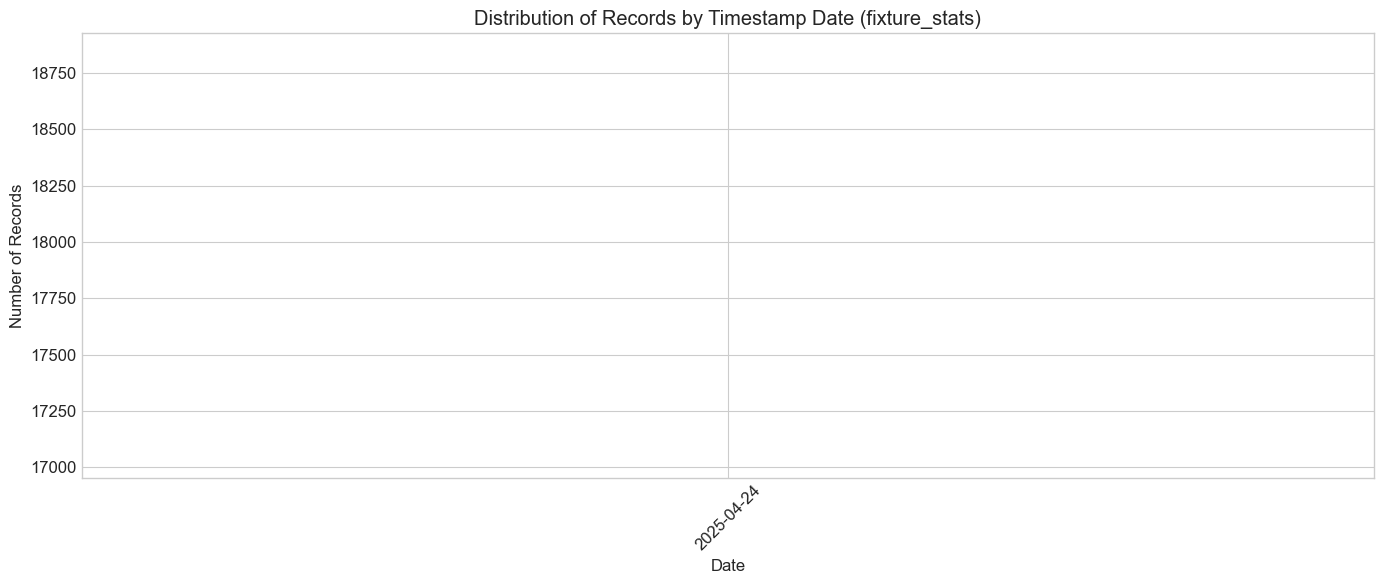

In [28]:
# Check timestamp validity across tables
def check_timestamp_validity(conn=None):
    """Check that created_at and updated_at timestamps are logical."""
    close_conn = False
    if conn is None:
        conn = get_db_connection()
        close_conn = True
    
    # Tables to check (those with timestamp columns)
    tables = ['leagues', 'seasons', 'teams', 'schedules', 'fixture_stats', 'fixture_odds']
    results = []
    
    for table in tables:
        try:
            # Query to check for timestamp issues
            query = f"""
                SELECT 
                    '{table}' AS table_name,
                    COUNT(*) AS total_rows,
                    SUM(CASE WHEN created_at IS NULL THEN 1 ELSE 0 END) AS null_created_at,
                    SUM(CASE WHEN updated_at IS NULL THEN 1 ELSE 0 END) AS null_updated_at,
                    SUM(CASE WHEN updated_at < created_at THEN 1 ELSE 0 END) AS illogical_timestamps,
                    MIN(created_at) AS earliest_created,
                    MAX(created_at) AS latest_created,
                    MIN(updated_at) AS earliest_updated,
                    MAX(updated_at) AS latest_updated
                FROM {table}
            """
            
            df = execute_query(query, conn)
            if not df.empty:
                results.append(df.iloc[0].to_dict())
            
        except Exception as e:
            # Table might not exist or doesn't have timestamp columns
            results.append({
                'table_name': table,
                'total_rows': 0,
                'null_created_at': 0,
                'null_updated_at': 0,
                'illogical_timestamps': 0,
                'earliest_created': None,
                'latest_created': None,
                'earliest_updated': None,
                'latest_updated': None
            })
    
    if close_conn:
        conn.close()
    
    return pd.DataFrame(results)

# Execute the function
timestamp_validity = check_timestamp_validity()
display(timestamp_validity)

# Highlight any tables with timestamp issues
tables_with_issues = timestamp_validity[
    (timestamp_validity['null_created_at'] > 0) | 
    (timestamp_validity['null_updated_at'] > 0) | 
    (timestamp_validity['illogical_timestamps'] > 0)
]

if not tables_with_issues.empty:
    print("\nTables with timestamp issues:")
    display(tables_with_issues)
else:
    print("\nNo timestamp issues found across tables.")

# For fixture_stats specifically, check 'timestamp' field consistency
try:
    stats_timestamp_analysis = execute_query("""
        SELECT 
            COUNT(*) AS total_rows,
            SUM(CASE WHEN timestamp IS NULL THEN 1 ELSE 0 END) AS null_timestamps,
            MIN(timestamp) AS earliest_timestamp,
            MAX(timestamp) AS latest_timestamp
        FROM fixture_stats
    """)
    
    print("\nFixture_stats specialized timestamp field analysis:")
    display(stats_timestamp_analysis)
    
    # Check for suspicious gaps or clusters in timestamps
    timestamp_distribution = execute_query("""
        SELECT 
            DATE(timestamp) AS date,
            COUNT(*) AS records_count
        FROM fixture_stats
        WHERE timestamp IS NOT NULL
        GROUP BY DATE(timestamp)
        ORDER BY DATE(timestamp)
    """)
    
    if not timestamp_distribution.empty:
        # Plot timestamp distribution
        plt.figure(figsize=(14, 6))
        plt.plot(timestamp_distribution['date'], timestamp_distribution['records_count'])
        plt.title('Distribution of Records by Timestamp Date (fixture_stats)')
        plt.xlabel('Date')
        plt.ylabel('Number of Records')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
except Exception as e:
    print(f"\nCould not analyze timestamp field in fixture_stats: {e}")

├── 5. Statistical Validity & Consistency

│   ├── 5.1 Value Ranges & Outliers

│   ├── 5.2 Internal Statistical Consistency

│   ├── 5.3 Score Consistency

│   └── 5.4 Temporal Consistency

Statistical description of first-half statistics:


,count,min,max,range,mean,std,25%,50%,75%
goals,6606.0,0.0,6.0,6.0,0.80,0.81,0.0,1.0,1.0
shots_on_target,6431.0,0.0,10.0,10.0,2.13,1.51,1.0,2.0,3.0
shots_off_target,6357.0,0.0,12.0,12.0,2.32,1.59,1.0,2.0,3.0
shots_total,6541.0,0.0,23.0,23.0,5.80,3.09,4.0,5.0,8.0
ball_possession,6601.0,0.0,100.0,100.0,68.99,21.15,52.0,65.0,88.0
corners,6399.0,0.0,12.0,12.0,2.32,1.77,1.0,2.0,3.0
fouls,6588.0,0.0,20.0,20.0,5.57,2.56,4.0,5.0,7.0
yellow_cards,5446.0,0.0,6.0,6.0,0.85,0.85,0.0,1.0,1.0
red_cards,3344.0,0.0,2.0,2.0,0.05,0.22,0.0,0.0,0.0
passes,6351.0,0.0,587.0,587.0,213.24,67.54,167.0,207.0,255.0



Extreme outliers for goals:
  Lower bound: -3.0
  Upper bound: 4.0
  Outlier values: [np.int64(5), np.int64(6)]
  Outlier count: 8

Extreme outliers for shots_on_target:
  Lower bound: -5.0
  Upper bound: 9.0
  Outlier values: [np.float64(10.0)]
  Outlier count: 1

Extreme outliers for shots_off_target:
  Lower bound: -5.0
  Upper bound: 9.0
  Outlier values: [np.float64(10.0), np.float64(12.0)]
  Outlier count: 2

Extreme outliers for shots_total:
  Lower bound: -8.0
  Upper bound: 20.0
  Outlier values: [np.float64(23.0)]
  Outlier count: 1

Extreme outliers for corners:
  Lower bound: -5.0
  Upper bound: 9.0
  Outlier values: [np.float64(10.0), np.float64(11.0), np.float64(12.0)]
  Outlier count: 10

Extreme outliers for fouls:
  Lower bound: -5.0
  Upper bound: 16.0
  Outlier values: [np.float64(17.0), np.float64(18.0), np.float64(20.0)]
  Outlier count: 5

Extreme outliers for yellow_cards:
  Lower bound: -3.0
  Upper bound: 4.0
  Outlier values: [np.float64(5.0), np.float64(6.0)

,fixture_id,column,value,lower_bound,upper_bound
0,242,goals,5.0,-3.0,4.0
1,1271,goals,5.0,-3.0,4.0
2,1304,goals,5.0,-3.0,4.0
3,1843,goals,5.0,-3.0,4.0
4,2562,goals,6.0,-3.0,4.0
...,...,...,...,...,...
235,5806,saves,6.0,-2.0,5.0
236,6206,saves,6.0,-2.0,5.0
237,6380,saves,6.0,-2.0,5.0
238,972,challenges,249.0,-6.0,15.0


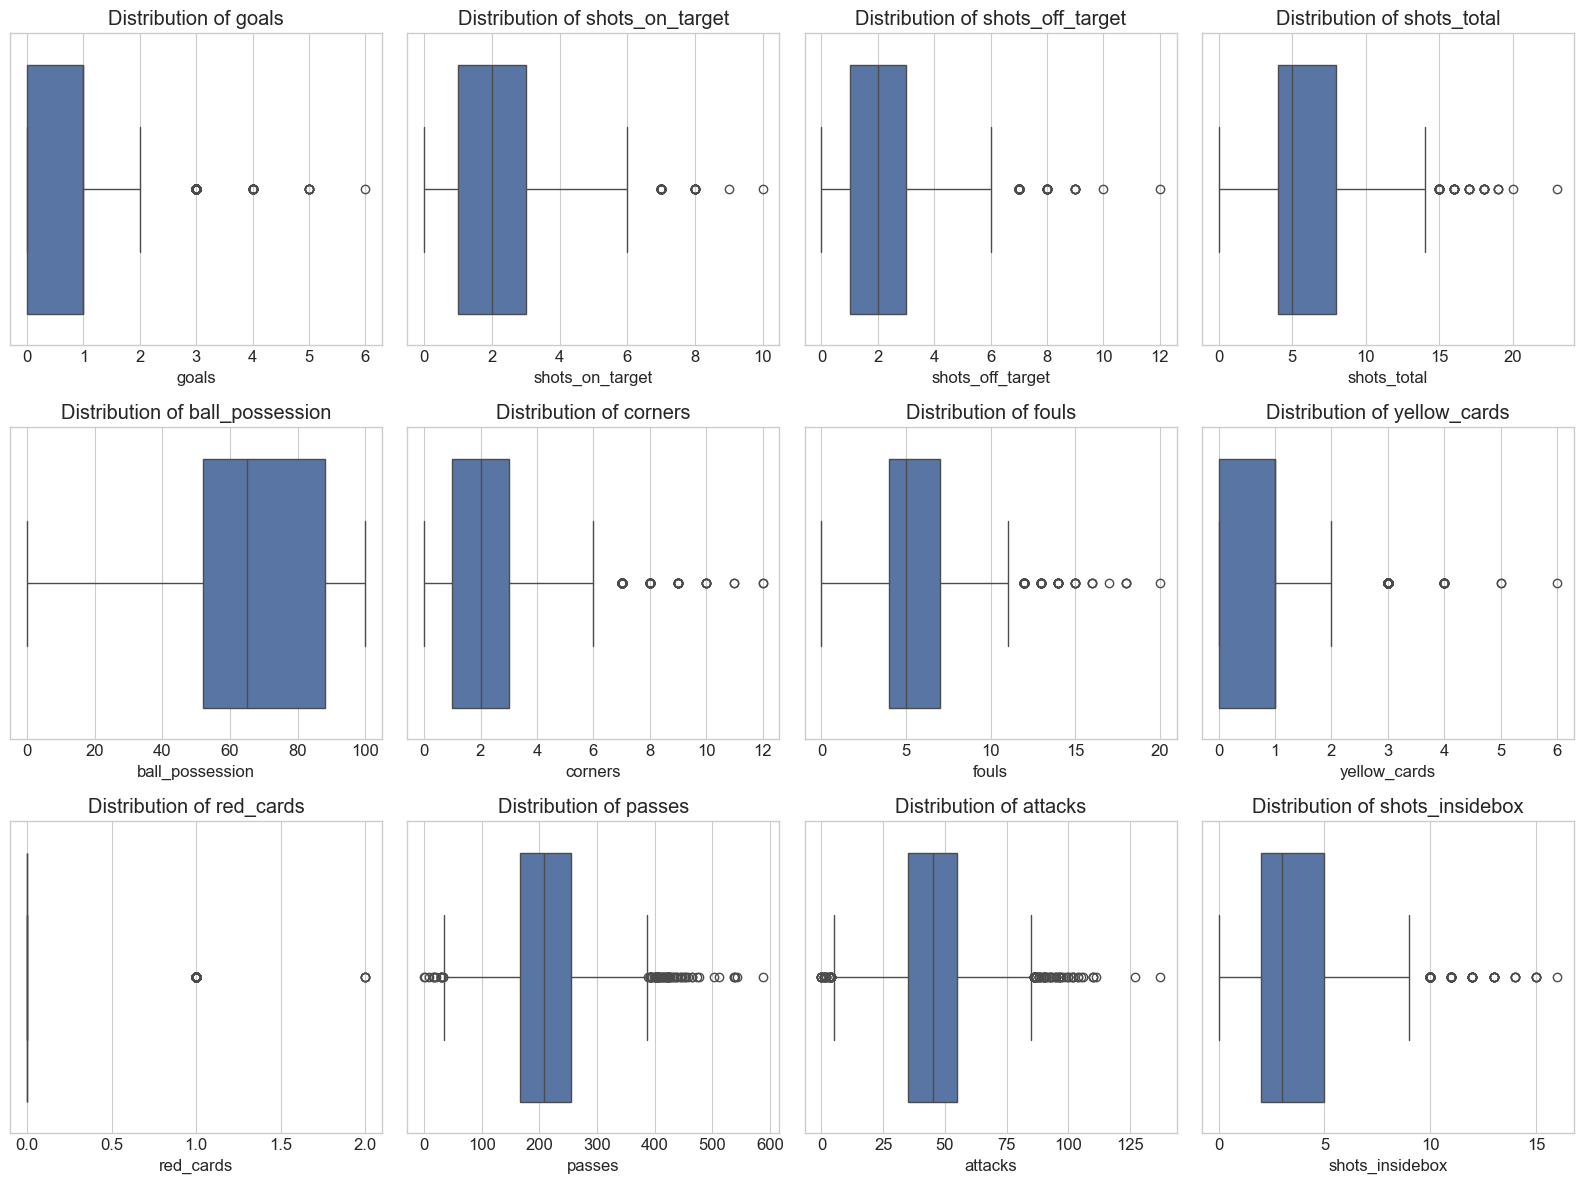

In [ ]:
# Get key stats from fixture_stats for first-half period including fixture_id and team_id
stats_data = execute_query("""
    SELECT 
        fixture_id, team_id,
        goals, shots_on_target, shots_off_target, shots_total, 
        ball_possession, corners, fouls, yellow_cards, red_cards,
        passes, attacks, shots_insidebox, saves, challenges
    FROM fixture_stats
    WHERE period = 'first_half'
    AND goals IS NOT NULL  -- Filter out rows with NULL key stats
""")

# Define stats columns (excluding identifier columns)
stats_columns = [col for col in stats_data.columns if col not in ['fixture_id', 'team_id']]

# Basic statistical description
print("Statistical description of first-half statistics:")
stats_description = stats_data[stats_columns].describe().transpose()
stats_description['range'] = stats_description['max'] - stats_description['min']
stats_description = stats_description[['count', 'min', 'max', 'range', 'mean', 'std', '25%', '50%', '75%']]
display(stats_description)

# Identify extreme outliers (beyond 3 IQRs)
all_outliers = []  # Create list to store all outlier records

for column in stats_columns:
    if stats_data[column].dtype in [np.int64, np.float64]:
        Q1 = stats_data[column].quantile(0.25)
        Q3 = stats_data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        col_outliers = stats_data[(stats_data[column] < lower_bound) | (stats_data[column] > upper_bound)]
        
        if not col_outliers.empty:
            # Add each outlier as a record with metadata - now using actual fixture_id and team_id
            for _, row in col_outliers.iterrows():
                all_outliers.append({
                    'fixture_id': row['fixture_id'],  # Using actual fixture_id
                    'team_id': row['team_id'],        # Including team_id for context
                    'column': column,
                    'value': row[column],
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                })
            
            print(f"\nExtreme outliers for {column}:")
            print(f"  Lower bound: {lower_bound}")
            print(f"  Upper bound: {upper_bound}")
            print(f"  Outlier values: {sorted(col_outliers[column].unique())}")
            print(f"  Outlier count: {len(col_outliers)}")

# Convert list to DataFrame after loop
outliers = pd.DataFrame(all_outliers)
if not outliers.empty:
    print("\nSummary of all outliers:")
    display(outliers)

# Plot distributions with boxplots to visualize outliers
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(stats_columns[:12]):  # Limit to 12 plots for readability
    if stats_data[column].dtype in [np.int64, np.float64]:
        ax = axes[i]
        sns.boxplot(x=stats_data[column], ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        
plt.tight_layout()
plt.show()

# Impossible value check
impossible_values = {
    'ball_possession': {'min': 0, 'max': 100},
    'shots_on_target': {'min': 0, 'max': None},
    'shots_total': {'min': 0, 'max': None},
    'goals': {'min': 0, 'max': None},
    'red_cards': {'min': 0, 'max': 11},  # Maximum players on field
    'passes': {'min': 0, 'max': None}
}

for stat, bounds in impossible_values.items():
    if stat in stats_data.columns:
        min_bound = bounds['min']
        max_bound = bounds['max']
        
        conditions = []
        if min_bound is not None:
            conditions.append(f"{stat} < {min_bound}")
        if max_bound is not None:
            conditions.append(f"{stat} > {max_bound}")
        
        if conditions:
            query = f"""
                SELECT 
                    fs.fixture_id,
                    fs.team_id,
                    t.name AS team_name,
                    fs.period,
                    fs.{stat} AS {stat}_value
                FROM fixture_stats fs
                LEFT JOIN teams t ON fs.team_id = t.team_id
                WHERE fs.period = 'first_half'
                AND ({' OR '.join(conditions)})
                ORDER BY fs.{stat}
            """
            
            impossible_records = execute_query(query)
            
            if not impossible_records.empty:
                print(f"\nFound {len(impossible_records)} records with impossible {stat} values:")
                display(impossible_records.head(10))